In [3]:
from processing import *
from glob import glob
from pathlib import Path

#input path to .d file(s) to process
base_dir = Path('S:/Mar - Imaging - M2 - DHAP/Negative Mode Data/Section10_exp2_animal9_wt_neg/')
d_files_paths = list(base_dir.rglob("*.d"))
d_files_paths_str = [str(path) for path in d_files_paths]
d_files_paths_str

print(d_files_paths_str)

['S:\\Mar - Imaging - M2 - DHAP\\Negative Mode Data\\Section10_exp2_animal9_wt_neg\\Section10_exp2_animal9_wt_neg.d']


In [21]:
def process_d_files(d_file_paths, return_one_imzml=False, raw_data=False, peak_pick=False, ppm=30, mz_range=(300,1000), height=None, threshold=None, prominence=None, sampling_rate=10):
    """
    Processes Bruker .d files for mass spectrometry analysis.

    Args:
        d_file_paths (list): List of paths to .d files.
        return_one_imzml (bool): If True, combines all files into one imzML file.
        raw_data (bool): If True, extracts raw profile data instead of line spectrum.
        peak_pick (bool): If True, performs peak picking.
        ppm (int): Parts per million for peak picking.
        mz_range (tuple): Tuple indicating the range of mz values to consider.
        height (float): Required height of peaks. None by default.
        threshold (float): Required threshold of peaks. None by default.
        prominence (float): Minimum peak prominence for peak picking.
        sampling_rate (int): Sampling rate for peak picking.

    Returns:
        None: Saves processed data to imzML files or combined imzML file.
    """
    dll = init_sdk()
    combined_spectra_dfs = []
    combined_coords = []
    combined_roi = []
    combined_paths = []
    
    for path in d_file_paths:
        print(f'Extracting data from {path}...please wait')
        
        if peak_pick:
            peak_indices = perform_peak_picking(path, dll, raw_data, sampling_rate, ppm, height, threshold, prominence)
            spectra_dfs, coords, roi, paths = extract_data(path, dll, raw_data, peak_indices)
        else:
            spectra_dfs, coords, roi, paths = extract_data(path, dll, raw_data)

        if return_one_imzml:
            combined_spectra_dfs.extend(spectra_dfs)
            combined_coords.extend(coords)
            combined_roi.extend(roi)
            combined_paths.extend(paths)
        else:
            # Construct the output filename from the original .d file's name
            base_filename = os.path.basename(path)
            new_filename = base_filename.replace('.d', '.imzML')
            output_path = os.path.join(os.path.dirname(path), new_filename)
            write_data_to_imzml(output_path, path, spectra_dfs, coords, roi, paths, peak_pick)

    if return_one_imzml:
        combined_output_path = rf"{d_file_paths[0]}\combined_processed.imzML"
        write_data_to_imzml(combined_output_path, d_file_paths[0], combined_spectra_dfs, combined_coords,combined_roi, combined_paths, peak_pick)
        print("Combined imzML file has been created.")
    
# Function to load imzML data into memory



def write_data_to_imzml(output_path, numpy_path, spectra_dfs, coords, roi, paths, peak_pick):
    """
    Write processed data to imzML file(s).

    Args:
        output_path (str): Base output path for imzML files.
        spectra_dfs (list): List of spectra dataframes to be written.
        coords (list): List of coordinates for each spectra dataframe.
        peak_pick (bool): Indicates if peak picking was performed.

    Returns:
        None
    """
    with ImzMLWriter(output_path) as writer:
        for df, coord in zip(spectra_dfs, coords):
            mzs = df['mz'].values
            intensities = df['intensity'].values
            writer.addSpectrum(mzs, intensities, coord)
            
    print(rf'saving numpy files to {numpy_path}\coords.np')
    np.save(rf"{numpy_path}\coords.npy", coords)
    np.save(rf"{numpy_path}\rois.npy", roi)
    np.save(rf"{numpy_path}\paths.npy", paths)
            

    print(f"Data successfully written to {output_path}")

In [4]:
%%time
#adjust height and prominence to to retain or remove low SNR features
process_d_files(d_files_paths_str, return_one_imzml=False, raw_data=True, peak_pick=True, ppm=50, mz_range=(150,1800), height=100, threshold = 0, prominence = 6, sampling_rate=20)

Extracting data from S:\Mar - Imaging - M2 - DHAP\Negative Mode Data\Section10_exp2_animal9_wt_neg\Section10_exp2_animal9_wt_neg.d...please wait
starting peak picking


getting sampled data for average spectrum: 100%|███████████████████████████████████| 4366/4366 [01:33<00:00, 46.76it/s]


peaks found


100%|████████████████████████████████████████████████████████████████████████████| 21830/21830 [11:16<00:00, 32.29it/s]


saving numpy files to S:\Mar - Imaging - M2 - DHAP\Negative Mode Data\Section10_exp2_animal9_wt_neg\Section10_exp2_animal9_wt_neg.d\coords.np
Data successfully written to S:\Mar - Imaging - M2 - DHAP\Negative Mode Data\Section10_exp2_animal9_wt_neg\Section10_exp2_animal9_wt_neg.d\processed.imzML
CPU times: total: 4h 36min 45s
Wall time: 19min 42s


In [5]:
%%time
#past pack in the imzML file written in the previous block
data = loadimzMLData('S:/Mar - Imaging - M2 - DHAP/Negative Mode Data/Section10_exp2_animal9_wt_neg/Section10_exp2_animal9_wt_neg.d/processed.imzML')

TODO: convert indices into real world coordinates
loaded spectra
file loaded
CPU times: total: 8min 58s
Wall time: 8min 58s


In [6]:
%%time
#be sure to use the SAME mz bins if processing multiple MSI datasets for downstream analysis!

mz_bins_use_neg = np.load('S:/Mar - Imaging - M2 - DHAP/Negative Mode Data/mz_bins_use_neg.npy') #path to mz bins use

#in the extractMZFeatures function, you can input a list of bins to bin the data to, or it will choose its own bins
intens_array, mz_bins_use, c = extractMZFeatures(data, ppm=30, mz_range=(150,1800), mz_bins = mz_bins_use_neg,rebinning=False, feature_n=0, threshold_value =0,peak_pick=False)

Constructing Datacube: 100%|██████████████████████████████████████████████████████| 4031/4031 [00:09<00:00, 413.00it/s]


CPU times: total: 27.9 s
Wall time: 27.8 s


In [25]:
intens_array.shape

(146, 4031, 183)

1179.7357818647336

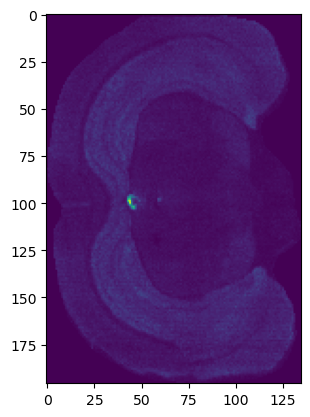

In [8]:
intens_arrayt = np.transpose(intens_array,(0,2,1))
#mzuse = np.argmin(abs(mz_bins_use_neg -   1572.8)) #find the mass channel closest to mz 713.4533
mz_bins_use = np.array(mz_bins_use)
mzuse = np.argmin(abs(mz_bins_use - 1173.7)) #find the mass channel closest to mz 713.4533

plt.imshow( intens_arrayt[:,:,mzuse])
mz_bins_use[mzuse]

In [28]:
# mz_bins_use_neg = mz_bins_use
# np.save('S:/Mar - Imaging - M2 - DHAP/Negative Mode Data/mz_bins_use_neg.npy',mz_bins_use_neg)

In [9]:
from scipy.ndimage import rotate

def rotate_hyperspectral_image(image, rotation_degrees):
    """
    Rotate each spectral slice of a 3D hyperspectral image by the specified number of degrees.
    The 'extra' space created by rotation is filled with zeros.

    Parameters:
    - image (numpy.ndarray): The 3D hyperspectral image to be processed, with dimensions [x, y, spectral].
    - rotation_degrees (float): The rotation angle in degrees. Positive values rotate counter-clockwise.

    Returns:
    - numpy.ndarray: The rotated 3D hyperspectral image with uniform dimensions across slices.
    """
    # Placeholder for the maximum dimensions after rotation
    max_height = 0
    max_width = 0

    # Determine the new dimensions after rotation for all slices
    for i in range(image.shape[2]):
        spectral_slice = image[:, :, i]
        # Temporarily rotate to find new dimensions
        temp_rotated_slice = rotate(spectral_slice, rotation_degrees, reshape=True, mode='constant', cval=0)
        max_height = max(max_height, temp_rotated_slice.shape[0])
        max_width = max(max_width, temp_rotated_slice.shape[1])

    # Initialize an array for the rotated image with determined max dimensions
    rotated_image = np.zeros((max_height, max_width, image.shape[2]))

    # Rotate each slice and fit it into the pre-determined dimensions
    for i in tqdm(range(image.shape[2]), desc="Rotating slices"):
        spectral_slice = image[:, :, i]
        rotated_slice = rotate(spectral_slice, rotation_degrees, reshape=True, mode='constant', cval=0)
        # Calculate starting indices to center the slice
        start_y = (max_height - rotated_slice.shape[0]) // 2
        start_x = (max_width - rotated_slice.shape[1]) // 2
        # Insert the rotated slice into the corresponding position in the rotated_image array
        rotated_image[start_y:start_y+rotated_slice.shape[0], start_x:start_x+rotated_slice.shape[1], i] = rotated_slice

    return rotated_image

Rotating slices: 100%|████████████████████████████████████████████████████████████| 4031/4031 [00:23<00:00, 174.42it/s]


1179.7357818647336

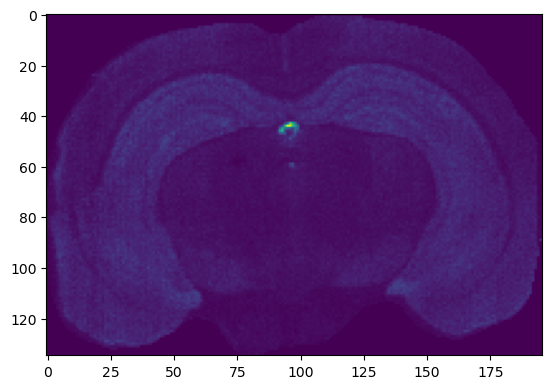

In [10]:
import numpy as np
from scipy.ndimage import rotate
from tqdm import tqdm


rotated_image = rotate_hyperspectral_image(intens_arrayt, 270)

intens_arrayt = np.transpose(intens_array,(0,2,1))
mzuse = np.argmin(abs(mz_bins_use -   1179.73)) #find the mass channel closest to mz 713.4533

plt.imshow( rotated_image[:,:,mzuse])
mz_bins_use[mzuse]

1179.7357818647336

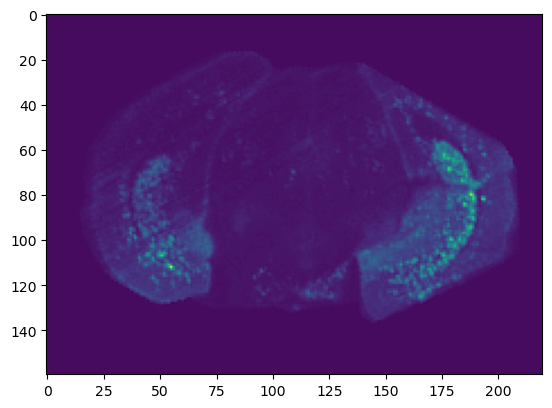

In [31]:

#Resize Image

# Example usage:
image = np.random.rand(225, 238, 8639)  # Simulated multichannel image
target_x, target_y = 225, 220  # Desired dimensions

resized_image = resize_image(rotated_image, 160, 220)

plt.imshow( resized_image[:,:,mzuse])
mz_bins_use_neg[mzuse]

In [ ]:
resized_image.shape

In [17]:
from scipy.io import savemat

def save_image_as_mat(image, file_path, var_name='image'):
    """
    Save a multichannel image as a .mat file with a custom variable name.

    Parameters:
    - image (numpy.ndarray): The multichannel image to be saved.
    - file_path (str): The path (including filename and .mat extension) to save the file to.
    - var_name (str): The variable name to be used in the MATLAB workspace.
    """
    # Create a dictionary with the custom variable name as the key
    data = {var_name: image}

    # Save the dictionary to a .mat file
    savemat(file_path, data)

    print(f"Image saved as {file_path} with variable name '{var_name}'")

In [32]:
# Example usage:
# Assuming resized_image is the rotated/resized image you want to save
file_path = 'S:/Mar - Imaging - M2 - DHAP/Negative Mode Data/Mat files neg mode/Animal_2_5xFAD_s1.mat'  # Specify the desired file path and name
Animal_2_5xFAD_s1 = resized_image
save_image_as_mat(Animal_2_5xFAD_s1, file_path, var_name='Animal_2_5xFAD_s1')


Image saved as S:/Mar - Imaging - M2 - DHAP/Negative Mode Data/Mat files neg mode/Animal_2_5xFAD_s1.mat with variable name 'Animal_2_5xFAD_s1'
